### Import Libraries

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

### Read Dataset

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

### Data cleaning and Preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Republican rift widens as Trump declines to en...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"August 2, 2016",true
1,Anderson Cooper Demands Answers After Trump’s...,"On Friday, Donald Trump broke a 37-year old pl...",News,"December 3, 2016",fake
2,French Catalans offer Puigdemont luxury safe-h...,PARIS (Reuters) - French Catalans have a villa...,worldnews,"October 24, 2017",true
3,Lebanon sentences Islamist cleric to death for...,BEIRUT (Reuters) - A hardline Sunni Muslim cle...,worldnews,"September 28, 2017",true
4,AUTHOR OF CHILDREN’S BOOKS BRAGS ABOUT GIVING ...,Because ripping babies from the womb and then ...,left-news,"Oct 2, 2015",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Republican rift widens as Trump declines to en...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,true
1,Anderson Cooper Demands Answers After Trump’s...,"On Friday, Donald Trump broke a 37-year old pl...",News,fake
2,French Catalans offer Puigdemont luxury safe-h...,PARIS (Reuters) - French Catalans have a villa...,worldnews,true
3,Lebanon sentences Islamist cleric to death for...,BEIRUT (Reuters) - A hardline Sunni Muslim cle...,worldnews,true
4,AUTHOR OF CHILDREN’S BOOKS BRAGS ABOUT GIVING ...,Because ripping babies from the womb and then ...,left-news,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,true
1,"On Friday, Donald Trump broke a 37-year old pl...",News,fake
2,PARIS (Reuters) - French Catalans have a villa...,worldnews,true
3,BEIRUT (Reuters) - A hardline Sunni Muslim cle...,worldnews,true
4,Because ripping babies from the womb and then ...,left-news,fake


In [11]:
# Convert to lowercase

# data['text'] = data['text'].apply(lambda x: x.lower())
# data.head()
data['text'] = data['text'].fillna('').astype(str).apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - u.s. republican preside...,politicsNews,true
1,"on friday, donald trump broke a 37-year old pl...",News,fake
2,paris (reuters) - french catalans have a villa...,worldnews,true
3,beirut (reuters) - a hardline sunni muslim cle...,worldnews,true
4,because ripping babies from the womb and then ...,left-news,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,washington reuters us republican presidential...,politicsNews,true
1,on friday donald trump broke a 37year old pled...,News,fake
2,paris reuters french catalans have a villa wi...,worldnews,true
3,beirut reuters a hardline sunni muslim cleric...,worldnews,true
4,because ripping babies from the womb and then ...,left-news,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,target
0,washington reuters us republican presidential ...,politicsNews,true
1,friday donald trump broke 37year old pledge ch...,News,fake
2,paris reuters french catalans villa swimming p...,worldnews,true
3,beirut reuters hardline sunni muslim cleric se...,worldnews,true
4,ripping babies womb carefully separating body ...,left-news,fake


In [16]:
data.isnull().sum()

text       0
subject    0
target     0
dtype: int64

In [17]:
targets = data.target

In [18]:
targets.head()

0    true
1    fake
2    true
3    true
4    fake
Name: target, dtype: object

In [19]:
label = data.target.value_counts()
print(label)

fake    23481
true    21417
Name: target, dtype: int64


C:\Users\HP\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


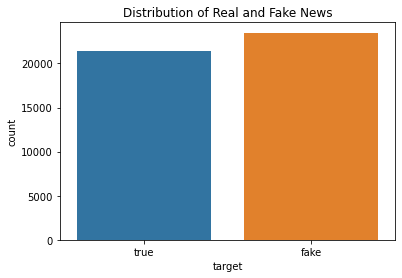

In [20]:
sns.countplot(data.target)
plt.title("Distribution of Real and Fake News")
plt.show()

### Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


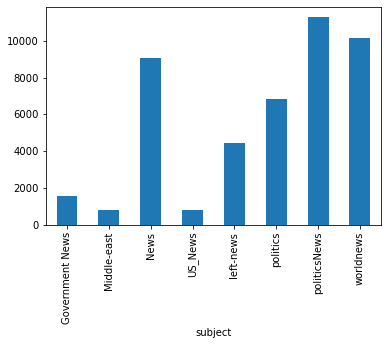

In [21]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


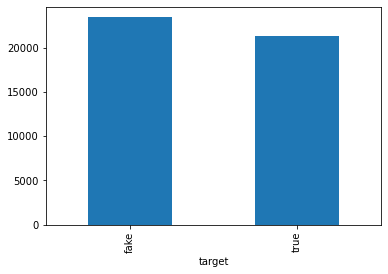

In [22]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

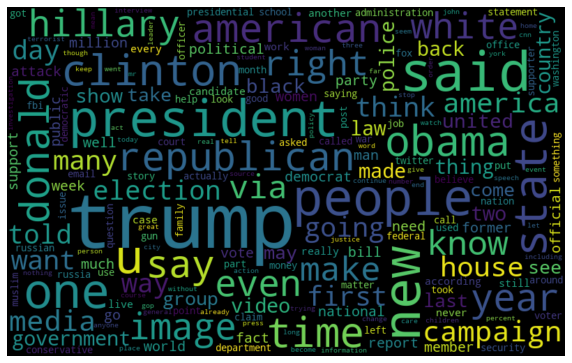

In [23]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

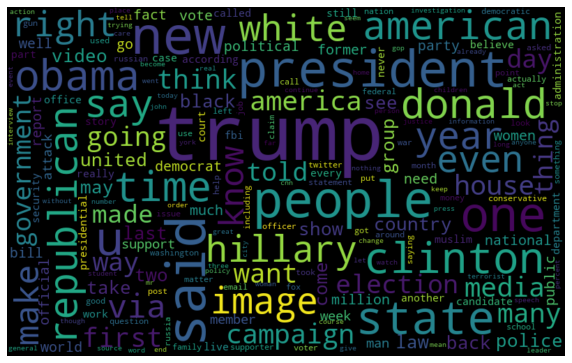

In [24]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [26]:
# Most frequent words counter    
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

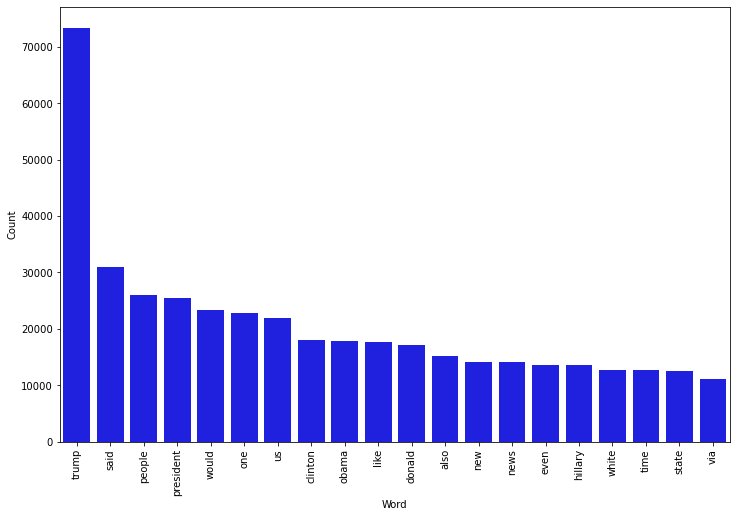

In [27]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

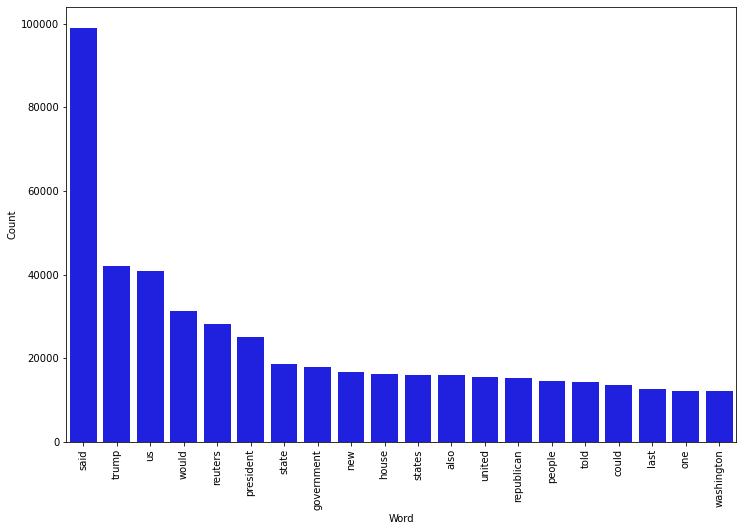

In [28]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

### Preparing the data

In [29]:
# splitting the dataset
x_train,x_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)


In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier

In [31]:

# initialize a Tfidfvectorizer
vector = TfidfVectorizer(stop_words = 'english',max_df=0.7)


In [32]:
# fit and transform
x_train = vector.fit_transform(x_train)
x_test= vector.transform(x_test)

In [33]:
# initialize a PassiveAggressiveClassifier
model = PassiveAggressiveClassifier(max_iter=50)
model.fit(x_train,y_train)

PassiveAggressiveClassifier(max_iter=50)

In [34]:
#prediction the test dataset
from sklearn.metrics import accuracy_score, confusion_matrix
prediction = model.predict(x_test)

from sklearn.metrics import classification_report
print(classification_report(list(y_test), prediction))

              precision    recall  f1-score   support

        fake       1.00      0.99      0.99      4727
        true       0.99      1.00      0.99      4253

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

score = accuracy_score(y_test,prediction)
print(f"Accuracy : {round(score*100,2)}%")

precision = precision_score(y_test, prediction,average='weighted')
print(f"Precision: {precision*100:.2f}%")

recall = recall_score(y_test, prediction,average='weighted')
print(f"Recall: {recall*100:.2f}%")

f1 = f1_score(y_test, prediction,average='weighted')
print(f"F1 score: {f1*100:.2f}%")

Accuracy : 99.47%
Precision: 99.47%
Recall: 99.47%
F1 score: 99.47%


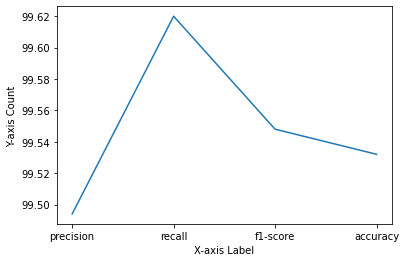

In [36]:
import matplotlib.pyplot as plt

# Example data
x_labels = ['precision', 'recall', 'f1-score', 'accuracy']
y_counts = [99.494, 99.62, 99.548, 99.532]

# Create the plot
plt.plot(x_labels, y_counts)

# Set the x-axis label
plt.xlabel('X-axis Label')

# Set the y-axis label
plt.ylabel('Y-axis Count')

# Show the plot
plt.show()


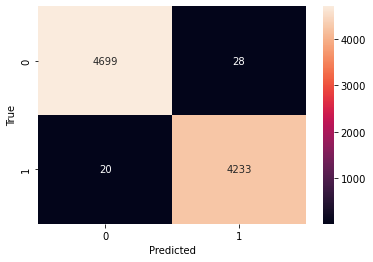

In [37]:
# Confusion metrics
cm = confusion_matrix(y_test, prediction)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

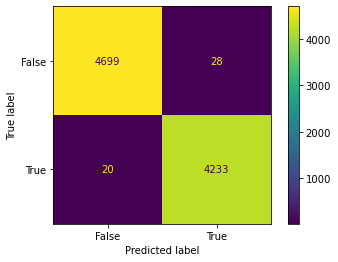

In [38]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,prediction)
  
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                            display_labels=[False, True])
  
cm_display.plot()
plt.show()

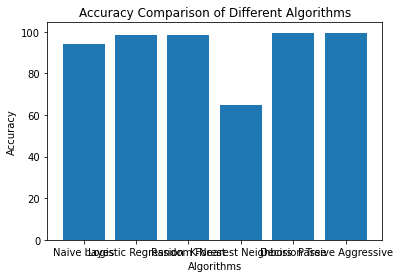

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Define the algorithms and their respective accuracies
algorithms = ['Naive bayes', 'Logistic Regression', 'Random Forest', 'K-Nearest Neighbors', 'Decision Tree', 'Passive Aggressive']
accuracies = [94.16, 98.54, 98.52, 64.81, 99.61, 99.59]

# Create a bar plot
fig, ax = plt.subplots()
ax.bar(algorithms, accuracies)

# Set the title and axis labels
ax.set_title('Accuracy Comparison of Different Algorithms')
ax.set_xlabel('Algorithms')
ax.set_ylabel('Accuracy')


# Show the plot
plt.show()

In [40]:
#save model
import pickle
filename = 'finalized_model.pk1'
pickle.dump(model,open(filename,'wb'))

In [42]:
#save vectorizer
filename = 'vectorizer.pk1'
pickle.dump(vector,open(filename,'wb'))